In [1]:
import numpy as np
from scipy import signal
from scipy.fft import fftshift
import matplotlib.pyplot as plt
from scipy.signal import welch

In [2]:
#read in data file and skip to data
file=open("/Users/Roslyn/Desktop/run-XXXII", "r")

In [3]:
with file as f:
    lines_after_6 = f.readlines()[7:]

In [4]:
#extract first two coloumns and convert to float
col1=[]
for x in lines_after_6:
    col1.append(float(x.split()[0]))
        
col2=[]
for x in lines_after_6:
    col2.append(float(x.split()[1]))
    
#combine real and imaginary parts to give list of complex data outputs
data=np.vectorize(complex)(col1, col2)

In [5]:
#enter constants
f_mode1 = 4.993017E6
f_mode2 = 5.505658500E+6 #- 2.8
kappa_1 = 0.000576417
kappa_2 = 0.000619449
Q1 = 4.4E7
Q2 = 4.84E7
dt=0.01
fs=100

w_mode1= 2*np.pi*f_mode1
w_mode2= 2*np.pi*f_mode2
tau1=Q1/w_mode1
tau2=Q2/w_mode2

h0=0.0005
trap=0.848

Zsquid= 1.2e6

In [6]:
data1=data[:10000000]

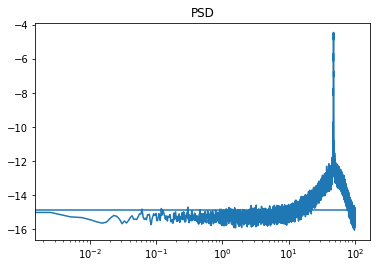

In [7]:
#PSD using Welch method 
f_1, S_1 = welch(
        (data1)-np.mean(data1), fs=fs, nperseg=(len(data1)/256),
         return_onesided=False, detrend=None, scaling='density', window='hanning')

#to plot log log have shifted frequency axis to positive 
plt.plot(f_1+abs(np.min(f_1)), 10*np.log10(S_1))
plt.title('PSD')
plt.xscale('log')


In [8]:
#SPECTRAL DISPLACEMENT DENSITY Su
#eq (8) GW Summary

#omega frequency axis, add mode freq 1 and convert from Hz to rad/s, and create squared axis 
w_1= [(x+f_mode1)*(2*np.pi) for x in f_1]
w_1sq= [x**2 for x in w_1]

#multiply 1/omega^2 list and Sv 
product1= [(1/a) * b for a, b in zip(w_1sq, S_1)]
 
#put into equation for Su(omega)
#10^-6 squared is a conversion from micro V to V
constants1 = (1/kappa_1**2)*(1/(Zsquid**2)*(10**(-6))**2)
Su1 = [x*(constants1) for x in product1]

Text(0.5, 1.0, 'Spectral Displacement Density')

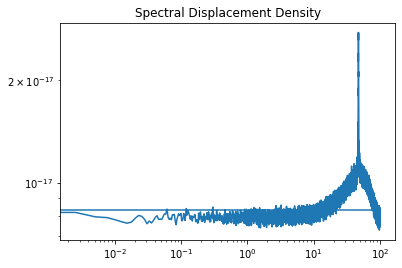

In [9]:
plt.plot(f_1+abs(np.min(f_1)), np.sqrt(Su1))
plt.xscale('log')
plt.yscale('log')
plt.title('Spectral Displacement Density')

In [10]:
#transfer function (equation 6 GW Summary)
def trans1(w):
    return np.absolute(((-w)**2*h0*trap/2)/((w*1j)**2+(w*1j)/tau1+w_mode1**2))

In [11]:
H_1=np.array(list(map(trans1,2*np.pi*(f_1+f_mode1))))

Text(0.5, 1.0, 'Transfer Function')

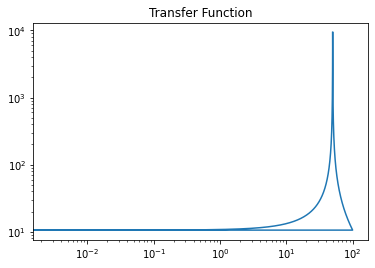

In [12]:
plt.plot(f_1+abs(np.min(f_1)), H_1)
plt.xscale('log')
plt.yscale('log')
plt.title('Transfer Function')

Text(0.5, 1.0, 'Strain Sensitivity ')

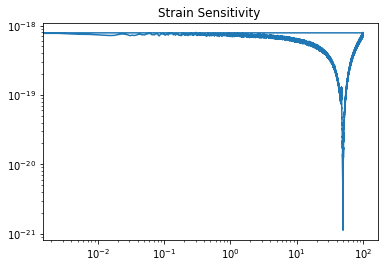

In [13]:
h_1=np.sqrt(Su1)/H_1

plt.plot(f_1+abs(np.min(f_1)), h_1)
plt.xscale('log')
plt.yscale('log')
plt.title('Strain Sensitivity ')

Text(0.5, 1.0, 'Transient Strain Sensitivity ')

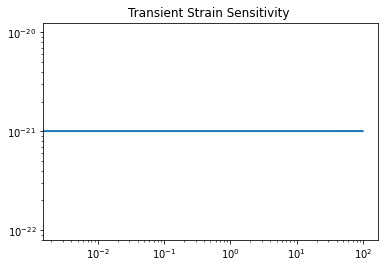

In [14]:
#DIFFERENCE ALGORITHM TESTING 

#create flat version of strain sensitivity to simulate simple broadband transient 
#print(np.min(h_1))
h_sim= [1e-21 for i in range(int(len(data1)/256))]

plt.plot(f_1+abs(np.min(f_1)), h_sim)
plt.xscale('log')
plt.yscale('log')
plt.title('Transient Strain Sensitivity ')

Text(0.5, 1.0, 'Transient Sim Spectral Displacement Density')

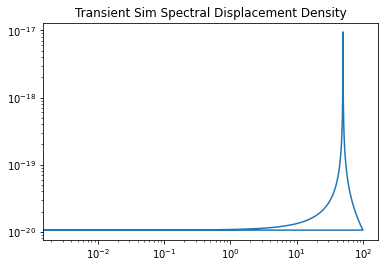

In [25]:
#multiply artificial h by H to get resulting square root of 
#spectral displacement density to add to data

sqrtSu_trans = [a*abs(b) for a,b in zip(h_sim, H_1)]

plt.plot(f_1+abs(np.min(f_1)), sqrtSu_trans)
plt.xscale('log')
plt.yscale('log')
plt.title('Transient Sim Spectral Displacement Density')


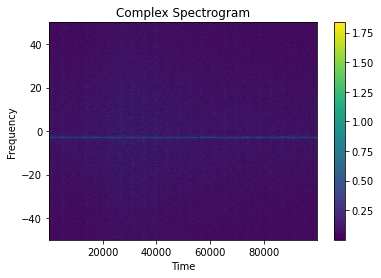

In [16]:
#PUT BACK INTO DIFFERENCING
#want to add this simulated signal to a time bin of data spectrogram 

#complex data spectrogram
f, t, Sxx = signal.spectrogram(data1-np.mean(data1), 100, nperseg=(int(len(data1)/256)), return_onesided=False, mode='complex')
plt.pcolormesh(t, fftshift(f), fftshift(abs(Sxx), axes=0), shading='gouraud')
plt.colorbar()
plt.ylabel('Frequency')
plt.xlabel('Time')
plt.title('Complex Spectrogram')
plt.show()

In [17]:
#ensuring frequency bins match length of simulated data 
print(len(f))
print(len(t))
#print(len(Sxx))
print(len(sqrtSu_trans))
np.shape(Sxx)

39062
292
39062


(39062, 292)

In [18]:
#Sxx[:,2]= [a+b for a,b in zip(Sxx[:,2],sqrtSu_trans)]

In [19]:
#create array with simulated signal in column index 2
Z=np.zeros((39062, 292))
Z[:,2]= [a+b for a,b in zip(Z[:,2],sqrtSu_trans)]
print(Z)

#add this to data spectrogram array 
Sxxsim= np.add(Sxx,Z)
print(Sxxsim)

[[0.00000000e+00 0.00000000e+00 9.32800000e-18 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 9.31851961e-18 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 9.29025093e-18 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [0.00000000e+00 0.00000000e+00 9.24370280e-18 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 9.29025091e-18 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 9.31851960e-18 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]]
[[-0.02153553+0.01167956j  0.00062777+0.00439836j -0.0039266 +0.01382116j
  ... -0.01507083-0.02835532j -0.11691243+0.01677394j
   0.0005162 +0.00104422j]
 [-0.09579591+0.19152409j  0.04594442+0.23361998j -0.21833396-0.31223623j
  ... -0.08120852-0.02943772j  0.15802561+0.04154333j
  -0.15158216+0.23358323j]
 [ 0.34294678-0.20062252j -0.04882456-0.01160481j  0.02024327+0.19205467j
  ...  0.0746075

In [26]:
#I think difference isn't currently showing because the Su added is so small compared to the 
#Sxx complex array as can be seen here - need some scaling 

In [20]:
#NORMALISATION : abs and median 
absnormSxxsim=[]

for i in range(0,len(Sxxsim)):
    absnormSxxsim.append(abs((Sxxsim[i]/np.median(abs(Sxxsim[i])))))

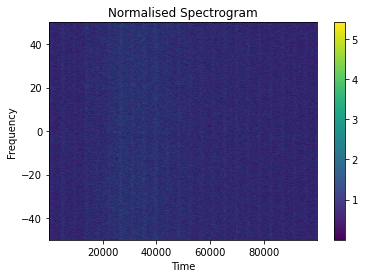

In [21]:
plt.pcolormesh(t, fftshift(f), fftshift(absnormSxxsim, axes=0), shading='gouraud')
plt.colorbar()
plt.ylabel('Frequency')
plt.xlabel('Time')
plt.title('Normalised Spectrogram')
plt.show()

In [22]:
#DIFFERENCING

timecols=np.transpose(absnormSxx)

#print(len(timecols))
#print(len(timecols[0]))

absdiff=[]
slice1=[]

for j in range(0,len(absnormSxxsim)):
    slice1.clear()
    for i in range(0,(len(t)-1)):
        slice1.append(abs(timecols[i+1][j]-timecols[i][j]))
    absdiff.append(slice1[:])
    
print(len(absdiff))
print(len(absdiff[0]))

292
39062
39062
291


In [23]:
#create time axis of matching dimension
difft=np.delete(t,0)

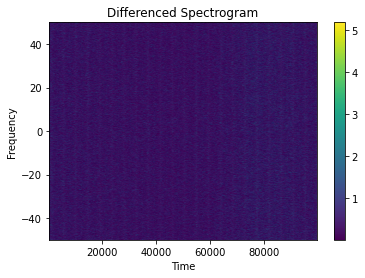

In [24]:
plt.pcolormesh(difft, fftshift(f), np.array(fftshift(absdiff)), shading='gouraud')
plt.colorbar()
plt.ylabel('Frequency')
plt.xlabel('Time')
plt.title('Differenced Spectrogram')
plt.show()